In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

これまで我々が見てきたNNは，フィードフォワードと呼ばれるネットワークで，流れが1方向でしかなかった.  
フィードフォワードでは時系列データをうまく扱うことができない．  
そこでリカレントニューラルネットワーク(RNN)の出番である．  
本章では，フィードフォワードの問題点を指摘し，RNNがその問題を解決することを示す．

# まとめ
- 言語モデル
    - 単語の羅列の自然さなどを確率として解釈するモデル．
    - RNNレイヤを利用した条件付き言語モデルは，それまで登場した単語の情報を記憶することができる．
    - 言語モデルの評価は，パープレキシティという正解の確率の逆数を用いた指標を使う．
- RNNレイヤ
    - ループする経路を持ち，隠れ状態として，その時刻で出力した単語(の分散表現)を内部に記憶し，学習に利用するレイヤ
        - 今自分なんて言った？を覚えておく
    - RNNのループ経路を展開することで，複数のRNNレイヤが繋がったネットワークを形作る．
    - これにより，長大なコンテキストを時系列データとして学習できる．  
        - これらの単語の次はこの単語がくる，という情報を学習していく
    - 展開されたRNNの重み更新は誤差逆伝播法で行うことができ，これをBack Propergation Through Time (BPTT)と呼ぶ．
- Time RNNレイヤ
    - 長い時系列データを学習する場合は，適当な長さでデータのまとまりを作り，それらのブロック単位で誤差逆伝播法を行う．これをTruncated BPTTと呼ぶ．
    - Truncated BPTTでは順伝播の時，データの順番は保ったまま，開始点をずらしてデータを学習させる．  
- RNNLM
    - RNNによる言語モデル，すなわち文章の自然性学習器を実装
    - これでは非常に大きなコーパスを扱うことができない．

# 確率と言語モデル

## word2vecを確率の視点から眺める

コーパス$w_1, w_2, ... w_T$が与えられているとき，$w_t$がターゲットとなる確率は，コンテキスト$w_{t-1}, w{t+1}$を使って
$$ P(w_t | w_{t-1}, w_{t+1})$$
と書ける．  
ここで，コンテキストの窓を非対称にして全て左側にコンテキストがあるとすると，$w_t$がターゲットとなる確率は
$$ P(w_t | w_{t-2}, w_{t-1})$$
このとき，CBOWモデルが扱う損失関数は
$$ L=-\log P(w_t|w_{t-2}, w_{t-1}) $$

## 言語モデル
言語モデルは，単語の並びがどれだけ自然であるかを確率で評価する．  
例えば，
- you say goodbye -> 0.092
- you say good die -> 0.000000000000032  

$ w_1, ..., w_m $ という順序で単語が出現する確率は，同時確率 $ P(w_1, ..., w_m) $ で表される．  
これを事後確率と確率の乗法定理 $P(A, B) = P(A|B)P(B)$ を使って分解すると　　
$$ P(w_1, ..., w_m) = P(w_m|w_1, ... w_{m-1})P(w_{m-1}|w_1, ... w_{m-2}) ... P(w_3|w_1, w_2)P(w_2|w_1)P(w_1)$$  
$$ = \prod_{t=1}^{m} P(w_t|w_1, ..., w_{t-1})$$

確率の乗法定理は，「AとBが両方同時に起こる確率 $P(A,B)$」は，「Bが起こる確率$P(B)$」と「Bが起こったあとにAが起きる確率P(A|B)」を掛け合わせたものである． 
また，$P(A, B) = P(B|A)P(A)$と書くこともできる．  
ここで注目すべきは，事後確率が対象の単語より左の全ての単語をコンテキストとした時の確率ということである．  
また， $P(w_t|w_1, ... w_{t-1})$を表すモデルは，条件付き言語モデルと呼ばれる．これを言語モデルと呼ぶ場合も多く見られる．

## CBOWモデルを言語モデルに？
CBOWモデルを無理やり言語モデルに適用するには，コンテキストのサイズをある値に限定することで近似的に表すことができる．  
$$ P(w_1, ..., w_m) = \prod_{t=1}^{m} P(w_t|w_1, ..., w_{t-1}) \approx \prod_{t=1}^{m} P(w_t|w_{t-2}, w_{t-1}) $$
  
マルコフ性  
未来の状態が現在の状態だけに依存して決まること．  
ここで，ある事象の確率がその直前のN個の事象だけに依存するとき，これを「N階マルコフ連鎖」という． 　
今は直前の2つに依存して次の単語が決まるので，2階マルコフ連鎖と呼べる．  
  
コンテキストのサイズは任意に設定できるが，固定する必要があるところに問題がある．  
例えば，コンテキストのサイズが10だが答えとなるTomなどの固有名詞が18個前にしかない時，この推論問題に答えることはできない．  
コンテキストを20にしたりすれば答えることはできる．  
  
しかし次にはコンテキスト内の単語の並びが無視されるという問題がある．  
例えば，(you,say)というコンテキストと(say,you)というコンテキストが同じものとして表される．  
これは，CBOWモデルの中間層を各コンテキストが共有しているために起きる．  
そこで，コンテキストごとに中間層を設けることで，すなわち複数の中間層を「連結(contcatenate)」することでこの問題に対処できる．  
しかし，そのようにするとコンテキストのサイズに比例して重みパラメータが増大してしまう．  

これらの問題を解決するのがRNNである．  
RNNは，コンテキストがどれだけ長くても，そのコンテキストの情報を記憶するメカニズムを持つ．  
  
ちなみに，実はword2vecの方が後に提案されている．  
RNNによる言語モデルでも単語の分散表現を獲得できるのだが，新たな語彙の追加しやすさや単語の分散表現の質の向上のためword2vecが提案された．

# RNNとは
Recurrent Neural Networkは日本語では「再起ニューラルネットワーク」や「循環ニューラルネットワーク」と呼ばれる．  
これに対してRecursive Neural Networkというものもあるが，こちらは主に木構造のデータを処理するためのネットワークで，RNNとは別物である．

## 循環するニューラルネットワーク
RNNの特徴は，閉路を持つことである．  
入力データを$(x_0, x_1, ... x_t, ...)$として， 出力データ$(h_0, h_1, ... h_t, ...)$ を自分にも入力する，すなわち閉路を持つ層をRNNレイヤと名付ける．　　
ここで，　$x_t$や$h_t$はベクトルを想定する．例えば，ある単語の分散表現を$x_t$としたりする．  
また，これまではデータが左から右へ流れていたが，以降は左右方向にレイヤが展開されるため，紙面の都合上，下から上へデータが流れるように描画される．  

## ループの展開
RNNレイヤは自身に出力データを流していたが，これを同じレイヤの別のRNNレイヤに流すことで，ループを展開する．  
左から右へ，同じレイヤのRNNレイヤが並び，その順が時系列の順番になっている．  
その出力が，左から$h_0, h_1, ... h_t$となる．  
「t番目の単語」や「t番目のRNNレイヤ」は，「時刻tの単語」や「時刻tのRNNレイヤ」というように，「時刻」という言葉でも表される．  
このとき，$h_t$は以下の計算で算出される．  
$$ h_t = \tanh (h_{t-1} W_h + x_t W_x + b) $$
RNNレイヤは重みを2つ持つ．  
入力$x$への重み$W_x$と一つ前のRNNの出力$h_{t-1}$に対する重み$W_h$である．  
これらの和にさらにバイアス$b$を加え， 活性化関数としてtanhを適用したものがRNNレイヤの出力になっている．  
  
この式では，RNNが$h_t$という現在の出力を状態として保持していて，上記の式で$h_t$が更新されていると見ることもできる．  
そのため，RNNレイヤは状態を持つレイヤやメモリを持つレイヤと呼ばれている．  
  
この$h_t$は「隠れ状態」や「隠れ状態ベクトル」と呼ばれている．  
  
多くの文献では，RNNレイヤの次の時刻への矢印はRNNレイヤから生えているが，本書では同じデータがコピーして分岐されたものであることを明示的に示すため，RNNレイヤの次の層への矢印から次の自国への矢印を伸ばすことにする．

## Backpropagation Through Time
ループを展開した後のRNNは，時間方向と逆方向に誤差逆伝播法を使って重みを更新していくことができる．  
このようなRNNにおける誤差逆伝播ん法をBackpropagation Through Time, 略してBPTTと呼ぶ.  
  
しかし，RNNレイヤを長く繋げると計算リソース(RNNが使うメモリ)が膨大になり，逆伝播の勾配も不安定になってしまう．　　

## Truncated BPTT
時間方向に長くなりすぎたネットワークを適当な場所で切り取って(truncate)小さなネットワークを複数作ること．  
これら小さくなったネットワークに対して，誤差逆伝播法を行う．  
正確には，ネットワークの逆伝播の時だけつながりを断ち切る．順伝播はそのまま行う．  
  
具体例を見ていく.  
1000個の長さのコーパス$x_0, x_1, ... x_{999}$があるとする． このコーパスは，複数の文が連結されたものであるとする．  
Truncated BPTTをするため，逆伝播のときは1000個連結されたRNNを「ブロック」に切り分ける．  
ここでは，それぞれのブロックのRNNのレイヤの長さが10になるようにする．  これによって，それぞれのブロックではそれより未来のデータについて考えなくていい．  

順伝播の時は，データを順番に(シーケンシャルに)与える必要がある．  
これまでミニバッチ学習ではデータをランダムに選んでいたが，Truncated BPTTでは順伝播の時にデータをシーケンシャルに与える必要がある．  
  
上の例でいうと，まずは一つ目のブロックの入力データ$x_0, ... x_9$をRNNレイヤに与え, forwardとbackwardを行う．  
次は，入力データ$x_{10}, ... ,x_{19}$をRNNに与え, forwardとbackwardを行う．  
このとき，前のブロックの出力$h_9$をこのブロックの先頭のRNNに与える必要があることに注意する．これによって順伝播のつながりは維持できる.  
以上のようにして順伝播とTruncated BPTTを進めていく．  

## Truncated BPTTのミニバッチ学習
RNNでTruncated BPTTする場合のミニバッチ学習では，開始位置をずらしたデータを利用する．  
これによって，各単語の前後関係を保ったまま，つまりシーケンシャルなまま，違うデータをRNNに与えることができる．  

例えば上の例では$x_0$からデータを与えていったが，別のデータでは$x_{500}$からデータを与えていく．  
なお，途中で終端に達した場合は，先頭に戻る．  

# RNNの実装
横方向にRNNをT個だけ繋げたものを一つの層として実装する．  
この層は，シーケンシャルなデータ$xs = (x_0, x_1, ... x_{T-1})$を入力すると，隠れ層へ$hs=(h_0, h_1, ..., h_{T-1})$を出力する．  
このひとまとまりにした層を「Time RNN」レイヤと呼ぶ．↔️ 1ステップの処理を行う「RNNレイヤ」  
後ほどTime Affine レイヤやTime Embeddingレイヤといった，時系列データをまとめて処理するレイヤも登場する．  

まず1ステップの処理を行うRNNクラスを作成し，Tステップの処理をまとめて行うレイヤをTimeRNNクラスとして完成させる．  

## RNNレイヤの実装
RNNレイヤの計算式を再掲
$$ h_t = \tanh (h_{t-1} W_h + x_t W_x + b) $$
$x_t$と$h_{t-1}$はミニバッチ処理のため，$N$個のデータを持つとする．各行がデータで，それらが列方向に並ぶ．  
そのため，$x_t$と$h_{t-1}$はそれぞれ$N \times H $, $N \times D$の行列になる．  
ここで，$H$は隠れ状態ベクトルの次元数， $D$は入力データの次元数である．  
RNNレイヤの計算では，次元数が以下のようになることに注意するのが重要である．

$$ h_{t-1} W_h + x_t W_x + b \Rightarrow h_t$$
$$ (N \times H) (H\times H) + (N \times D) (D \times H) + (N \times H) \Rightarrow (N \times H) $$  

以下この式とシステムに従いRNNレイヤを実装する．

In [2]:
class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b] # 初期重みをparamsに設定
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)] # 初期勾配をgradsに設定
        self.cache = None # BPTT用のキャッシュ変数(メモリ)
    
    def forward(self, x, h_prev): # 入力データと前の時刻の出力
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)
        
        self.cache = (x, h_prev, h_next)
        return h_next
    
    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache
        
        # tanhの逆伝播
        dt = dh_next * (1 - h_next ** 2)
        
        # 加算ノードはdtをそのまま前のレイヤに返す
        
        # b方向へのrepeatの逆伝播
        db = np.sum(dt, axis=0)
        
        # h_prev方向へのMatMulの逆伝播
        dWh = h_prev.T @ dt
        dh_prev = dt @ Wh.T
        
        # x方向へのMatMulの逆伝播
        dWx = x.T @ dt
        dx = dt @ Wx.T
        
        self.grads[0][...] = dWx # 3点リーダによって，浅いコピー(参照のコピー)ではなく深いコピー(値のコピー)を行う．
        self.grads[1][...] = dWh
        self.grads[2][...] = db
        
        return dx, dh_prev

ここでちょっと逆伝播の復習

- 加算ノードの逆伝播  
上流から入ってきた勾配$\frac{\partial L}{\partial z}$をそのまま受け流す. 3個以上の加算ノードでも同様にそのまま受け流す．
$$ z = x + y $$
$$ \frac{\partial z}{\partial x} = 1, \frac{\partial z}{\partial y} = 1 $$
上流で発生した損失Lに対するxの勾配
$$　\frac{\partial L}{\partial x} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial x} = \frac{\partial L}{\partial z} \cdot 1 = \frac{\partial L}{\partial z}$$
上流で発生した損失Lに対するyの勾配
$$ \frac{\partial L}{\partial y} = \frac{\partial L}{\partial z} \cdot \frac{\partial z}{\partial y} = \frac{\partial L}{\partial z} \cdot 1 = \frac{\partial L}{\partial z}$$  

<br><br>
- Repeatノードの逆伝播
RNNレイヤの実装では，N個のミニバッチにそれぞれ同じ重さベクトルbを加算している．  
これは分岐ノードの一般形であるRepeatノードの処理が行われていることになる．  
分岐ノード，Repeatノードでは，上流からやってきた重みを全て足し合わせて下流に返す．  
Repeatノードの逆伝播は，$D\times N$の上流からの勾配をN個の方向に足し合わせ，D次元のベクトルを作り出し，そのベクトルを勾配とする．

<br><br>
- 行列の積(Matrix Multiply: MatMul)の逆伝播  
p30, 31ではシグマを使ってもうちょい厳密に書いているが，自分の理解を書いてみる．まずは結果から
$$ y = xW $$
$$ (N \times H) = (N \times D)(D \times H) $$
$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y}W^{\top}, \frac{\partial L}{\partial W} = x^{\top} \frac{\partial L}{\partial y} $$
$$ (N \times D) = (N \times H)(H \times D), (D \times H) = (D \times N)(N \times H) $$
<br>

例えば，以下のような場合を考える．
$$ y = xW = \left( \begin {array}{ccc} a & b & c \end{array} \right) \left( \begin {array}{ccc} 1 & 2 & 3 \\ 4 & 5 & 6 \\ 7 & 8 & 9 \end{array} \right) = \left( \begin {array}{ccc} 1a+2b+3c & 4a+5b+6c & 7a+8b+9c \end {array} \right) $$

このとき， [ベクトルをベクトルで微分する計算の定義](https://qiita.com/AnchorBlues/items/8fe2483a3a72676eb96d)を使って

$$ \frac{\partial y}{\partial x} = \left( \begin{array}{ccc} \frac{\partial y_1}{\partial a} & \frac{\partial y_2}{\partial a} & \frac{\partial y_3}{\partial a}\\ \frac{\partial y_1}{\partial b} & \frac{\partial y_2}{\partial b} & \frac{\partial y_3}{\partial b} \\ \frac{\partial y_3}{\partial c} & \frac{\partial y_2}{\partial c} & \frac{\partial y_3}{\partial c}\end{array} \right) =\left( \begin{array}{ccc} 1 & 4 & 7 \\ 2 & 5 & 8 \\ 3 & 6 & 9 \end{array} \right) = W^\top$$
つまり，
$$ \frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} W^\top $$ 
$\frac{\partial L}{\partial W}　= x^\top \frac{\partial L}{\partial y}$も同様に求められる．(ベクトル$y$を行列$W$で微分)
<br><br>
- tanhの逆伝播
$$ y = \tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$$
の微分を求める．商の微分法を使って
$$ \frac{\partial \tanh(x)}{\partial x} = \frac {({e^x + e^{-x}})({e^x + e^{-x}}) - ({e^x - e^{-x}})({e^x - e^{-x}})}{({e^x + e^{-x}})^2} $$
$$ = 1 - \Bigl\{ \frac {({e^x - e^{-x}})}{({e^x + e^{-x}})} \Bigr\}^2 $$
$$ = 1 - \tanh(x)^2 = 1 - y^2 $$
よって, 上流からの勾配$\frac{\partial L} {\partial y}$を使って
$$ \frac{\partial L} {\partial x} = \frac{\partial L} {\partial y} \cdot \frac{\partial y} {\partial x} = \frac{\partial L} {\partial y} (1 - y^2) $$
を下流に返せば良い．  
ここでyは順伝播の時に保持しておく．RNNレイヤの実装でいうh_next， 最終的な出力を使うことになる．

## Time RNN レイヤの実装
T個のRNNレイヤで構成されるTime RNNレイヤを実装する．  
Time RNNレイヤは隠れ状態hをメンバ変数として保持し，ブロックに分割した時に次のブロックへhを渡す．  
隠れ状態を引き継ぐかどうかはstatefulという引数で調整する．

In [3]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False): # stateful: 状態を持つ，という意味
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None # 複数のRNNレイヤをリストとして持つ予定
        self.h, self.dh = None, None # forwardの最後の出力(次のブロックへ）を保持，　backwardの最後(先頭)の出力（前のブロックへ)を保持
        self.stateful = stateful # Falseのとき，forwardのたびに最初のRNNレイヤの隠れ状態をゼロ行列で初期化する． (ステートレス)
    
    def set_state(self, h):
        self.h = h
    
    def reset_state(self):
        self.h = None
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape # ミニバッチ数，　文章の長さ，　分散表現の次元数(語彙数)
        D, H = Wx.shape # 分散表現の次元数(語彙数), 隠れ層のサイズ
        
        self.layers = [] # forwardのたびにlayersをリセットしているが，self.hによってまた作るlayersを次のブロックとして扱える．
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None: 
            self.h = np.zeros((N, H), dtype='f')
        
        # 長さTのRNNループを展開
        for t in range(T):
            layer = RNN(*self.params) # ブロック内では同じ重みを使うようだ
            self.h = layer.forward(xs[:, t, :], self.h) # tの初回が別のブロックから渡されるかがstatefulによって決められることになる．
            hs[:, t,  :] = self.h # 全行(ミニバッチ全て), ｔ列(ｔ番目の単語), 全チャネル(単語の分散表現ベクトル全体) の出力をこのRNNレイヤの出力とする
            self.layers.append(layer)
        
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape
        
        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0] # Wx, Wh, b
        
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh) # 上流からの勾配(dhs)と次の時刻(dh)の勾配を合算して下流(dxs)と前の時刻(dh)に渡す
            dxs[:, t, :] = dx
            
            # Time RNNレイヤの勾配は全てのRNNレイヤの勾配の合計
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
        
        # Time RNNレイヤのgradsに今回のbackwardの勾配をDeepコピー
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        
        # 前の時刻のブロックの全体に渡すhの勾配
        self.dh = dh
    
        return dxs # 下流への勾配

In [4]:
# hs[:, t, :]がよくわからんかったので実験

print("2次元の場合")
A = np.array([[1,2], [3,4], [5,6]]) # コロン選択はnumpy Arrayでないとできない

print(A[0, :], "\n") # 0行全列
print(A[:, 0], "\n") # 全行0列 (列リストになるわけではない．1次元にされる)
print(A[:, 0].reshape(A.shape[0], 1), "\n") #　全行0列を元の形に直す

print("3次元の場合")
N = 5 # ミニバッチ数
T = 2 # 文章(コンテキスト)の長さ
H = 3 # 隠れ層のサイズ

hs = np.random.randn(N, T, H) # 5行 2列 3チャネル
print(hs)

for t in range(T):
    print()
    hs[:, t, :] = np.zeros((N, H), dtype='f') #　全行 ｔ列 全チャネル をゼロに， つまり文章の中の単語ごとの操作
    print(hs)

2次元の場合
[1 2] 

[1 3 5] 

[[1]
 [3]
 [5]] 

3次元の場合
[[[ 0.7244363   2.36289107  1.12872244]
  [ 1.4658667   0.05321955 -2.10676959]]

 [[-0.49554816 -1.01913243 -1.60841229]
  [-2.00337127  0.26873345 -1.24602126]]

 [[ 0.32095664 -0.22189829 -0.18614914]
  [-0.71893641 -0.34189917  0.76536774]]

 [[ 0.65678681  0.00362619 -0.17187461]
  [-0.03693075 -1.073377   -0.00784708]]

 [[-1.05595228 -0.06559255 -0.19441635]
  [-2.72967355  0.43765403 -0.36158333]]]

[[[ 0.          0.          0.        ]
  [ 1.4658667   0.05321955 -2.10676959]]

 [[ 0.          0.          0.        ]
  [-2.00337127  0.26873345 -1.24602126]]

 [[ 0.          0.          0.        ]
  [-0.71893641 -0.34189917  0.76536774]]

 [[ 0.          0.          0.        ]
  [-0.03693075 -1.073377   -0.00784708]]

 [[ 0.          0.          0.        ]
  [-2.72967355  0.43765403 -0.36158333]]]

[[[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [

# 時系列データを扱うレイヤの実装
RNNLM: RNN Language Model: RNN言語モデル: RNNによる単語の並びの自然性判定

## RNNLMの全体図
$w_t$ -> Embedding -> RNN -> Affine -> Softmax -> $y_t$となる．  
RNNレイヤの出力はRNNレイヤ自身にも入力される.  
RNNレイヤは時間方向に展開できる．  
  
出力層$y_t$には単語ごとの確率分布が出てくる．  
学習済みのRNNLMにおいて，単語IDが0の入力がyouならば，その出力はsayの確率が高い分布が出力される．  
このことから，RNNはyouの次にはsayが来る，という時系列,文脈を記憶していることがわかる．  

## Timeレイヤの実装
時間軸に展開される複数のRNNをTimeRNNとして実装したように，Affineレイヤ，EmbeddingレイヤもTime hogeレイヤとして実装する必要がある．  
AffineレイヤもEmbeddingレイヤもただT個並べるだけだが，Affineレイヤは行列計算としてまとめて処理することで効率がよくなる．  
TimeSoftmaxレイヤはCrossEntropyErrorレイヤと合わせて，TimeSoftmaxWithLossレイヤとして実装する．  
TimeSoftmaxWithLossレイヤは複数のSoftmaxWithLossレイヤを持ち，それぞれがスコアと正解ラベルから，スカラで損失$L_0, L_1, ... L_{T-1}$を出力する．  
それらの平均をとった$\frac{1}{T} (L_0, L_1, ... L_{T-1})$がTimeSoftMaxWithLossの損失となる．  
Timeレイヤの実装はcommon/time_layers.pyにある．

# RNNLMの学習と評価

# RNNLMの実装

In [5]:
from common.time_layers import TimeEmbedding, TimeAffine, TimeSoftmaxWithLoss

class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn
        
        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f') # Xavierの初期値， 1/sqrt(n)の標準偏差を持つ分布にする (n: 前層のノード個数)詳しくは後述
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f') # 言語モデルを扱う研究では，0.01 * np.random.uniform(...)のような初期値を扱うことが多いらしい．
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')
        
        # レイヤの初期化
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]
        
        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads
        
    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss
    
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout
    
    def reset_state(self):
        self.rnn_layer.reset_state()

なぜ$\frac{1}{\sqrt{n}}$で割ると標準偏差を$\frac{1}{\sqrt{n}}$にできるのか？
$$ ave = \frac{a + b + c}{3} $$
$$ \begin{eqnarray*} 
    std 
    &=&\sqrt{ \frac{1}{3}\sum_{i=1}^{N} (data_i - ave)^2 } \\
    &=&\frac{1}{3\sqrt{3}}\sqrt{(2a-b-c)^2+(2b-a-c)^2+(2c-a-b)^2} \\
    &=&\frac{1}{3\sqrt{3}}\sqrt{(4a^2+b^2+c^2-4ab+2bc-4ac)+(a^2+4b^2+c^2-4ab-4bc+2ac)+(a^2+b^2+4c^2+2ab-4bc-4ac)} \\
    &=&\frac{1}{3\sqrt{3}}\sqrt{4a^2+a^2+a^2 +b^2+4b^2+b^2 +c^2+c^2+4c^2 -4ab-4ab+2ab +2bc-4bc-4bc -4ac+2ac-4ac} \\
    &=&\frac{1}{3\sqrt{3}}\sqrt{6a^2 +6b^2 +6c^2 -6ab -6bc -6ac} \\
\end{eqnarray*}$$

$$ a, b, c \leftarrow \frac{a}{\sqrt{3}}, \frac{b}{\sqrt{3}}, \frac{c}{\sqrt{3}} $$

$$ \begin{eqnarray*} 
    std 
    &=& \frac{1}{3\sqrt{3}}\sqrt{2a^2 +2b^2 +2c^2 -2ab -2bc -2ac} \\
    &=& \frac{\sqrt{2}}{3\sqrt{3}}\sqrt{a^2 +b^2 +c^2 -ab -bc -ac}\\
\end {eqnarray*} $$
$$ \sqrt{a^2 +b^2 +c^2 -ab -bc -ac} = \frac{3}{\sqrt{2}}$$
$a,b,c$は確率変数? 
$$ \sqrt{{V[a]}^2 +{V[b]}^2 +{V[c]}^2 -{V[a]}{V[b]} -{V[b]}{V[c]} -{V[a]}{V[c]}} = \frac{3}{\sqrt{2}}$$
$V[a] = V[b] = V[c]=1$なので
$$ \sqrt{{V[a]}^2 +{V[b]}^2 +{V[c]}^2 -{V[a]}{V[b]} -{V[b]}{V[c]} -{V[a]}{V[c]}} = \frac{3}{\sqrt{2}}$$

そういうわけじゃなさそう？  
確率変数$x$の標準正規分布$f(x)$で$ x \leftarrow \frac{x}{\sqrt{n}} $としたとき，標準偏差が$\frac{\sigma}{\sqrt{n}}=\frac{1}{\sqrt{n}}$になる？

標準正規分布の確率密度関数
$$ f(x) = \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}} $$
確率変数$x$の分散
$$ V[x] = \int_{-\infty}^{\infty} x^2 \frac{1}{\sqrt{2\pi}}e^{-\frac{x^2}{2}} = 1$$
．  
.  
.  
わかった  
.  
.  
.  
分散の公式
$$ V[aX] = a^2V[X] $$
$a = \frac{1}{\sqrt{n}}$とおくと
$$ V[\frac{1}{\sqrt{n}}X] = \frac{1}{n}V[X] $$
標準偏差は
$$ \sqrt{\frac{1}{n} V[X]} = \frac{1}{\sqrt{n}} \sqrt{V[X]} $$
これより，確率変数に$\frac{1}{\sqrt{n}}$をかけることは，標準偏差を$\frac{1}{\sqrt{n}}$倍することになる．  
すなわち,標準正規分布から抽出を行うrandnで作った配列全体に$\frac{1}{\sqrt{n}}$をかけると標準偏差を$\frac{1}{\sqrt{n}} \cdot \sigma = \frac{1}{\sqrt{n}} \cdot 1 = \frac{1}{\sqrt{n}}$にすることができる．

## 言語モデルの評価
言語モデルの予測性能の良さの評価の基準として**パープレキシティ(perprexity: 困惑させるもの)**が用いられる．  
パープレキシティは次の単語で，正解のものが出力される確率の逆数．なので低い方がいい．  
例えば，youの次にsayが来る確率が0.8なら，パープレキシティは$\frac{1}{0.8} = 1.25$  
これは，次に出現する候補が1個ほどに絞れたことを意味する．  
複数の入力データに対するパープレキシティの式は以下になる．  
$$ L = -\frac{1}{N} \sum_{n} \sum_{k} t_{nk} \log{y_{nk}} $$
$$ perplexity = e^L $$
これがどうも確率の逆数になっているらしい  
$$ L = \sum_{n} \sum_{k} \log{y_{nk} ^ {-\frac{t_{nk}}{N}}} $$
$$ e^L = \exp{L} = \exp{\sum_{n} \sum_{k} \log{y_{nk} ^ {-\frac{t_{nk}}{N}}} } = \prod_{n} \prod_{k} y_{nk} ^ {-\frac{t_{nk}}{N}} =
{ \prod_{n} \prod_{k} \frac{1}{y_{nk} ^ { \frac{t_{nk}}{N} } } }$$
ここで，$t_{nk}$は正解の単語のみが1のone-hotベクトルなので，$k$についてプロダクトをとると，不正解の$y_{nk}^{t_{nk}}$は1になる.  
なので，$y_n$を正解の単語の出現確率とすると，  
$$ perplexity = \Big( \prod_{n} \sqrt[N]{y_n} \Big) ^ {-1} = \Big( \sqrt[N]{\prod_{n} y_n} \Big) ^ {-1}$$
よってパープレキシティは，次の時刻に正解の単語が出現する確率のN乗平均の逆数をとっていることがわかる．  
パープレキシティは情報理論の分野では，平均分岐数とも呼ばれる．  

## RNNLMの学習コード
PTBデータセットの先頭1000個のデータを使って学習を行う．  
1000個以上になって来ると結果が悪くなる．その原因と解決方法は次章で触れる．

corpus size: 1000, vocabulary size 418
| epoch 1 | perplexity 388.37
| epoch 2 | perplexity 257.00
| epoch 3 | perplexity 221.02
| epoch 4 | perplexity 214.49
| epoch 5 | perplexity 204.61
| epoch 6 | perplexity 201.26
| epoch 7 | perplexity 198.36
| epoch 8 | perplexity 197.13
| epoch 9 | perplexity 192.13
| epoch 10 | perplexity 192.80
| epoch 11 | perplexity 188.55
| epoch 12 | perplexity 192.28
| epoch 13 | perplexity 190.88
| epoch 14 | perplexity 191.86
| epoch 15 | perplexity 189.91
| epoch 16 | perplexity 186.01
| epoch 17 | perplexity 184.70
| epoch 18 | perplexity 182.74
| epoch 19 | perplexity 182.28
| epoch 20 | perplexity 185.79
| epoch 21 | perplexity 183.01
| epoch 22 | perplexity 180.57
| epoch 23 | perplexity 179.19
| epoch 24 | perplexity 178.38
| epoch 25 | perplexity 179.70
| epoch 26 | perplexity 176.39
| epoch 27 | perplexity 175.21
| epoch 28 | perplexity 171.67
| epoch 29 | perplexity 168.26
| epoch 30 | perplexity 162.17
| epoch 31 | perplexity 166.52
| epoch 3

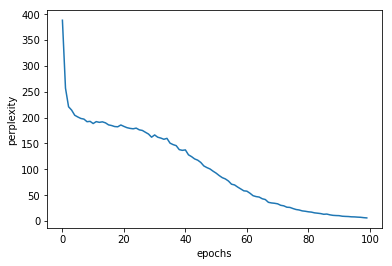

In [6]:
from common.optimizer import SGD
from dataset import ptb

# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100 # RNNの隠れ状態ベクトルの要素数
time_size = 5 # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み(データセットを小さくする)
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1] # 入力
ts = corpus[1:] # 正解ラベル
data_size = len(xs)
print('corpus size: %d, vocabulary size %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# 1. ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # 2. ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size] # data範囲外になったら元に戻るようMOD演算を使用
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1 # 次の単語へ． リセットするひつようはない．
            
        # 勾配を求め，パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1
        
    # 3. エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f' % (epoch + 1, ppl) )
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0
    
plt.plot(ppl_list)
plt.xlabel("epochs")
plt.ylabel('perplexity')
plt.show()

## RNNLMのTrainerクラス
上記の学習を簡単に行えるように，RnnTrainerクラスが提供される．

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 419.36
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 362.18
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 251.74
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 220.23
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 210.60
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 208.56
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 201.84
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 200.75
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.55
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 189.76
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.67
| epoch 12 |  iter 1 / 19 | time 0[s] | perplexity 189.60
| epoch 13 |  iter 1 / 19 | time 0[s] | perplexity 192.54
| epoch 14 |  iter 1 / 19 | time 0[s] | perplexity 186.54
| epoch 15 |  iter 1 / 19 | time 0[s] | perplexity 186.34
| epoch 16 |  iter 1 / 19 | time 0[s] | perplexity 191.00
| epoch 17 |  iter 1 / 19 | time 0[s] | perplexity 189.69
| epoch 18 |  iter 1 / 

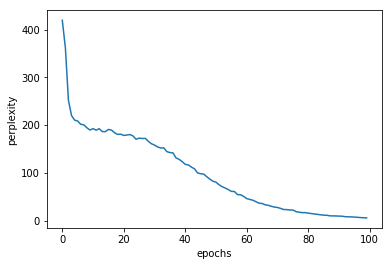

In [9]:
from common.trainer import RnnlmTrainer

model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)
trainer.fit(xs, ts, max_epoch, batch_size, time_size)

plt.plot(trainer.ppl_list)
plt.xlabel("epochs")
plt.ylabel('perplexity')
plt.show()